In [ ]:
import numpy as np
import pandas as pd
import re
import random
import csv
import warnings
import string
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from nltk.corpus import stopwords, wordnet
# initialize our lemmatizer for usage in our subsequent function
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('vader_lexicon')
from nltk import FreqDist
from nltk.corpus import stopwords, wordnet
# initialize our lemmatizer for usage in our subsequent function
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem import PorterStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
from spacy import displacy
from spacytextblob.spacytextblob import SpacyTextBlob
import en_core_web_sm

import textacy
from textacy import extract

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.utils import class_weight
from xgboost import XGBClassifier

from gensim.models import Word2Vec
import gensim.downloader as api
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

from wordcloud import WordCloud
warnings.simplefilter(action='ignore')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shaochen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2024-03-18 18:28:36.702663: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# TL;DR

CountVectorizer:
- Oversampling helps
- Not removing stopwords helps
- Scaling does not helps (in LR)

TF-IDF unigram:
- Oversampling increases overfitting but helps with test F1 as well
- Removing stopwords is marginally better
- Scaling helps (in LR)

TF-IDF bigram:
- perform worse than the above 2

gensim:
- both glove.twitter.27B.200d and glove.840B.300d cause my kernel to stop, included pipeline below if you want to explore

Conclusion
- Try removing stopwords with TF-IDF
- Try not removing stopwords with CountVectorizer
- Try Oversampling

# Dataset Exploration

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
df_train = pd.read_csv('fulltrain.csv',names = ['label', 'text'])
df_test = pd.read_csv('balancedtest.csv',names = ['label', 'text'])
df_train.head()

label  \
0      1   
1      1   
2      1   
3      1   
4      1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
print(f"#train samples before removing duplicates :{df_train.shape[0]}")
# we remove completely duplicated rows
df_train = df_train.drop_duplicates(keep='first')
print(f"#train samples before removing duplicates :{df_train.shape[0]}")
print(f"#train text after removing duplicates :{df_train.text.nunique()}")

#train samples before removing duplicates :48854
#train samples before removing duplicates :48652
#train text after removing duplicates :48652


In [ ]:
# label distribution
df_train.label.value_counts()

3    17870
1    13911
4     9932
2     6939
Name: label, dtype: int64

In [ ]:
# label distribution in percentage
round(df_train.label.value_counts()/df_train.shape[0],2)*100

3    37.0
1    29.0
4    20.0
2    14.0
Name: label, dtype: float64

In [ ]:
print(f"#test samples before removing duplicates :{df_test.shape[0]}")
# we remove completely duplicated rows
df_test = df_test.drop_duplicates(keep='first')
print(f"#test samples after removing duplicates :{df_test.shape[0]}")
print(f"#test text after removing duplicates :{df_test.text.nunique()}")

#test samples before removing duplicates :3000
#test samples after removing duplicates :2990
#test text after removing duplicates :2990


In [ ]:
tokenizer = RegexpTokenizer(r'[A-Za-z0-9_@#\']+')
def get_tokenized_counts(txt):
    tokens_ct = len(tokenizer.tokenize(txt))
    sent_ct = len(sent_tokenize(txt))
    tokens_per_sent = tokens_ct/sent_ct
    return pd.Series([tokens_ct, sent_ct, tokens_per_sent])
tokenized_count_cols = ['tokens_ct', 'sent_ct', 'tokens_per_sent']

In [ ]:
# get number of tokens, sentences, and tokens per sentence
df_train[tokenized_count_cols] = df_train.text.apply(get_tokenized_counts)
df_test[tokenized_count_cols] = df_test.text.apply(get_tokenized_counts)

In [ ]:
def check_capitalized(txt):
    tokens_list = tokenizer.tokenize(txt)
    sum = 0
    for token in tokens_list:
        if token[0].isupper():
            sum = sum+1
    return sum

In [ ]:
# Counting capitalized word
df_train['capitalized_word_ct'] = df_train.text.apply(check_capitalized)
df_test['capitalized_word_ct'] = df_test.text.apply(check_capitalized)

In [ ]:
print(f"mean tokens count Satire :{np.mean(df_train.tokens_ct[df_train.label==1])}")
print(f"mean tokens count Hoax :{np.mean(df_train.tokens_ct[df_train.label==2])}")
print(f"mean tokens count Propaganda :{np.mean(df_train.tokens_ct[df_train.label==3])}")
print(f"mean tokens count Reliable :{np.mean(df_train.tokens_ct[df_train.label==4])}")

mean tokens count Satire :305.310689382503
mean tokens count Hoax :196.34990632656002
mean tokens count Propaganda :927.2870173475098
mean tokens count Reliable :455.8494764397906


In [ ]:
print(f"mean sent count Satire :{np.mean(df_train.sent_ct[df_train.label==1])}")
print(f"mean sent count Hoax :{np.mean(df_train.sent_ct[df_train.label==2])}")
print(f"mean sent count Propaganda :{np.mean(df_train.sent_ct[df_train.label==3])}")
print(f"mean sent count Reliable :{np.mean(df_train.sent_ct[df_train.label==4])}")

mean sent count Satire :12.50348644957228
mean sent count Hoax :11.135033866551376
mean sent count Propaganda :45.800783435926135
mean sent count Reliable :20.259061619009263


In [ ]:
# reliable & satire have relatively more tokens per sentence
print(f"mean tokens per sent count Satire :{np.mean(df_train.tokens_per_sent[df_train.label==1])}")
print(f"mean tokens per sent count Hoax :{np.mean(df_train.tokens_per_sent[df_train.label==2])}")
print(f"mean tokens per sent count Propaganda :{np.mean(df_train.tokens_per_sent[df_train.label==3])}")
print(f"mean tokens per sent count Reliable :{np.mean(df_train.tokens_per_sent[df_train.label==4])}")

mean tokens per sent count Satire :27.622489557732372
mean tokens per sent count Hoax :18.240794105682053
mean tokens per sent count Propaganda :20.32285887721423
mean tokens per sent count Reliable :25.16080302928862


In [ ]:
# Hoax have relatively more cap count
print(f"mean cap count Satire :{np.mean(df_train.capitalized_word_ct[df_train.label==1])}")
print(f"mean cap count Hoax :{np.mean(df_train.capitalized_word_ct[df_train.label==2])}")
print(f"mean cap count Propaganda :{np.mean(df_train.capitalized_word_ct[df_train.label==3])}")
print(f"mean cap count Reliable :{np.mean(df_train.capitalized_word_ct[df_train.label==4])}")

mean cap count Satire :38.27395586226727
mean cap count Hoax :42.457270500072056
mean cap count Propaganda :146.94902070509232
mean cap count Reliable :70.78966975432944


In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
def entities_count(txt):
    doc = nlp(txt)
    gpe_count = 0
    date_count = 0
    cardinal_count = 0
    org_count = 0
    person_count = 0
    norp_count = 0
    money_count = 0
    percent_count = 0
    ordinal_count = 0
    loc_count = 0
    time_count = 0
    work_of_art_count = 0
    entity_count = len(doc.ents)
    for token in doc.ents:
        if token.label_ =='GPE':
            gpe_count = gpe_count+1
        elif token.label_ == 'DATE':
            date_count = date_count+1
        elif token.label_ == 'CARDINAL':
            cardinal_count = cardinal_count+1
        elif token.label_ == 'ORG':
            org_count = org_count+1
        elif token.label == 'PERSON':
            person_count = person_count+1
        elif token.label_ == 'NORP':
            norp_count = norp_count+1
        elif token.label_ == 'MONEY':
            money_count = money_count+1
        elif token.label_ == 'PERCENT':
            percent_count = percent_count+1
        elif token.label_ == 'ORDINAL':
            ordinal_count = ordinal_count+1
        elif token.label_ == 'LOC':
            loc_count = loc_count+1
        elif token.label_ == 'TIME':
            time_count = time_count+1
        elif token.label_ == 'WORK_OF_ART':
            work_of_art_count = work_of_art_count+1
    return pd.Series([entity_count, gpe_count, date_count,
                      cardinal_count, org_count, person_count,
                      norp_count, money_count, percent_count,
                      ordinal_count, loc_count, time_count,
                      work_of_art_count])

entity_cols = ['entity_count', 'gpe_count', 'date_count',
               'cardinal_count','org_count', 'person_count',
               'norp_count', 'money_count', 'percent_count',
               'ordinal_count', 'loc_count', 'time_count',
               'work_of_art_count']

df_train[entity_cols] = df_train['text'].apply(entities_count)
df_test[entity_cols] = df_test['text'].apply(entities_count)

In [ ]:
df_train.columns

Index(['label', 'text', 'capitalized_word_ct', 'entity_type_list',
       'punct_list', 'entity_count', 'gpe_count', 'date_count',
       'cardinal_count', 'org_count', 'person_count', 'norp_count',
       'money_count', 'percent_count', 'ordinal_count', 'loc_count',
       'time_count', 'work_of_art_count'],
      dtype='object')

In [ ]:
sentiment_cols = ['blob_sentiment_score','blob_subj_score']
nlp.add_pipe('spacytextblob')
def textblob_sent(txt):
    doc = nlp(txt)
    return pd.Series([doc._.blob.polarity, doc._.blob.subjectivity])
df_train[sentiment_cols] = df_train.text.apply(textblob_sent)
df_test[sentiment_cols] = df_test.text.apply(textblob_sent)

In [ ]:
def sentiment_scores(sentence):
# Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
# polarity_scores method of SentimentIntensityAnalyzer
# oject gives a sentiment dictionary.
# which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    # decide sentiment as positive, negative and neutral
    return sentiment_dict['compound']

df_train['vader_sentiment_score']  = df_train.text.apply(sentiment_scores)
df_test['vader_sentiment_score']  = df_test.text.apply(sentiment_scores)

In [ ]:
def count_svo(txt):
#     print(txt)
    doc = textacy.make_spacy_doc(txt, lang="en_core_web_sm")
    svo_lst = list(extract.subject_verb_object_triples(doc))
    if len(svo_lst)==0:
        svo_count = 0
        is_first_sub_svo = 0
        entity_svo_count = 0
    else:
        svo_count = len(svo_lst)
        first_sub_in_triple = svo_lst[0].subject
#         print(first_sub_in_triple)
        sub_toks = [tok for tok in doc if (tok.dep_ == "nsubj"
                                           or tok.dep_ == "nsubjpass"
                                           or tok.dep_ == "csubj")]
#         print(sub_toks)
        if sub_toks[0] == first_sub_in_triple[0]:
            is_first_sub_svo = 1
        else: is_first_sub_svo = 0

        entities_lst = [t.text for t in list(doc.ents)]
        entity_svo_count = 0
        for i in svo_lst:
            if i.subject[0].text in entities_lst:
                entity_svo_count = entity_svo_count+1
    noun_count = len([tok for tok in doc if (tok.pos_ == "NOUN")])
    pronoun_count = len([tok for tok in doc if (tok.pos_ == "PROPN")])
    verb_count = len([tok for tok in doc if (tok.pos_ == "VERB")])
    abj_count = len([tok for tok in doc if (tok.pos_ == "ADJ")])
    num_count = len([tok for tok in doc if (tok.pos_ == "NUM")])
    punct_count = len([tok for tok in doc if (tok.pos_ == "PUNCT")])
    intj_count = len([tok for tok in doc if (tok.pos_ == "INTJ")])
    return pd.Series([svo_count, is_first_sub_svo, entity_svo_count,
                     noun_count, pronoun_count, verb_count, abj_count, num_count,
                     punct_count, intj_count])

svo_cols = ['svo_count', 'is_first_sub_svo', 'entity_svo_count',
           'noun_count', 'pronoun_count', 'verb_count',
           'abj_count', 'num_count', 'punct_count',
           'intj_count']

df_train[svo_cols] =  df_train['text'].apply(count_svo)
df_test[svo_cols] =  df_test['text'].apply(count_svo)

In [ ]:
# differentiating punctuations (based on distribution analysis)
df_train['has_qn_mark'] = df_train.text.str.contains('?', regex=False).astype(int)
df_train['has_exclamation_mark'] = df_train.text.str.contains('!', regex=False).astype(int)
df_train['has_single_quote'] = df_train.text.str.contains("'", regex=False).astype(int)
df_train['has_ellipsis'] = df_train.text.str.contains('...', regex=False).astype(int)
df_train['has_em_dash'] = df_train.text.str.contains('--', regex=False).astype(int)
df_train['has_colon'] = df_train.text.str.contains(':', regex=False).astype(int)
df_train['has_said'] = df_train.text.str.contains('said', regex=False).astype(int)

df_test['has_qn_mark'] = df_test.text.str.contains('?', regex=False).astype(int)
df_test['has_exclamation_mark'] = df_test.text.str.contains('!', regex=False).astype(int)
df_test['has_single_quote'] = df_test.text.str.contains("'", regex=False).astype(int)
df_test['has_ellipsis'] = df_test.text.str.contains('...', regex=False).astype(int)
df_test['has_em_dash'] = df_test.text.str.contains('--', regex=False).astype(int)
df_test['has_colon'] = df_test.text.str.contains(':', regex=False).astype(int)
df_test['has_said'] = df_test.text.str.contains('said', regex=False).astype(int)

In [ ]:
# using default stopwords list
tokenizer = RegexpTokenizer(r'[A-Za-z0-9_@#\']+')
stop_words_list = set(nltk.corpus.stopwords.words('english'))
def remove_stop_words(words):
    return list(filter(lambda x: x not in stop_words_list, words))


In [ ]:
# define manual stop words (I didn't use this step because it doesn't seem very necessary)
def remove_manual_stop_words(words):
    return list(filter(lambda x: x not in stop_words_manual, words))

#df_train['remove_manual_stop_words'] = df_train.apply(lambda x: remove_manual_stop_words(x['text_tokenized']), axis = 1)
#df_test['remove_manual_stop_words'] = df_test.apply(lambda x: remove_manual_stop_words(x['text_tokenized']), axis = 1)

In [ ]:
# # define lemmatizer
# def spacy_lemmatizer(lst):
#     token_lst = []
#     for token in lst:
#         token_lst.append(nlp(token)[0].lemma_.lower())
#     return token_lst

In [ ]:
# define lemmatizer
def spacy_lemmatizer_fast(text_col):
    lemmatize_list_full = []
    for txt in nlp.pipe(text_col):
        lemmatize_list = []
        for token in txt:
            lemmatize_list.append(token.lemma_)
        lemmatize_list_full.append(lemmatize_list)
    return lemmatize_list_full

In [ ]:
# lemmatize_list_full = []
# for txt in nlp.pipe(df_train['text_tokenized_joined']):
#     lemmatize_list = []
#     for token in txt:
#         lemmatize_list.append(token.lemma_)
#     lemmatize_list_full.append(lemmatize_list)

In [ ]:
# define stemmer
ps = PorterStemmer()
def perform_stemming(lst):
    for index, word in enumerate(lst):
        # if '<' in word:
        #     continue
        # if '>' in word:
        #     continue
        lst[index] = ps.stem(word)
    return lst

In [ ]:
# 1. casefolding
df_train['text_lower'] = df_train.apply(lambda x: x['text'].lower(), axis = 1)
df_test['text_lower'] = df_test.apply(lambda x: x['text'].lower(), axis = 1)

# 2. tokenize words
df_train['text_tokenized'] = df_train.apply(lambda x: tokenizer.tokenize(x['text_lower']), axis = 1)
df_test['text_tokenized'] = df_test.apply(lambda x: tokenizer.tokenize(x['text_lower']), axis = 1)
# 3. lemmatize tokens
df_train['text_tokenized_joined'] = df_train.apply(lambda x: ' '.join(x['text_tokenized']), axis = 1)
df_train['text_lemmatized'] = spacy_lemmatizer_fast(df_train['text_tokenized_joined'])

df_test['text_tokenized_joined'] = df_test.apply(lambda x: ' '.join(x['text_tokenized']), axis = 1)
df_test['text_lemmatized'] = spacy_lemmatizer_fast(df_test['text_tokenized_joined'])
# 4. stem tokens
df_train['text_stemmed'] = df_train.apply(lambda x: perform_stemming(x['text_tokenized']), axis = 1)
df_test['text_stemmed'] = df_test.apply(lambda x: perform_stemming(x['text_tokenized']), axis = 1)
# 5. join lemmatized/stemmed words to prepare ngram text
df_train['ngram_text_lemmatized'] = df_train.apply(lambda x: ' '.join(x['text_lemmatized']), axis = 1)
df_train['ngram_text_stemmed'] = df_train.apply(lambda x: ' '.join(x['text_stemmed']), axis = 1)

df_test['ngram_text_lemmatized'] = df_test.apply(lambda x: ' '.join(x['text_lemmatized']), axis = 1)
df_test['ngram_text_stemmed'] = df_test.apply(lambda x: ' '.join(x['text_stemmed']), axis = 1)
# 6. count unique lemmatized tokens & get ratio (didn't apply for stemmed tokens because stemming is not as clean)
df_train['unique_tokens_ct'] = df_train.apply(lambda x: len(set(x['text_lemmatized'])), axis = 1)
df_train['unique_tokens_ratio'] = df_train['unique_tokens_ct']/df_train['tokens_ct']

df_test['unique_tokens_ct'] = df_test.apply(lambda x: len(set(x['text_lemmatized'])), axis = 1)
df_test['unique_tokens_ratio'] = df_test['unique_tokens_ct']/df_test['tokens_ct']

In [ ]:
#7. remove default stopwords and lemmatize
df_train['text_removed_stopwords'] = df_train.apply(lambda x: remove_stop_words(x['text_tokenized']), axis = 1)
df_test['text_removed_stopwords'] = df_test.apply(lambda x: remove_stop_words(x['text_tokenized']), axis = 1)

df_train['text_removed_stopwords_joined'] = df_train.apply(lambda x: ' '.join(x['text_removed_stopwords']), axis = 1)
df_train['text_removed_stopwords_lemmatized'] = spacy_lemmatizer_fast(df_train['text_removed_stopwords_joined'])

df_test['text_removed_stopwords_joined'] = df_test.apply(lambda x: ' '.join(x['text_removed_stopwords']), axis = 1)
df_test['text_removed_stopwords_lemmatized'] = spacy_lemmatizer_fast(df_test['text_removed_stopwords_joined'])

#7. remove manual stopwords and lemmatize
df_train['text_removed_manual_stopwords'] = df_train.apply(lambda x: remove_manual_stop_words(x['text_tokenized']), axis = 1)
df_test['text_removed_manual_stopwords'] = df_test.apply(lambda x: remove_manual_stop_words(x['text_tokenized']), axis = 1)

df_train['text_removed_manual_stopwords_joined'] = df_train.apply(lambda x: ' '.join(x['text_removed_manual_stopwords']), axis = 1)
df_train['text_removed_manual_stopwords_lemmatized'] = spacy_lemmatizer_fast(df_train['text_removed_manual_stopwords_joined'])

df_test['text_removed_manual_stopwords_joined'] = df_test.apply(lambda x: ' '.join(x['text_removed_manual_stopwords']), axis = 1)
df_test['text_removed_manual_stopwords_lemmatized'] = spacy_lemmatizer_fast(df_test['text_removed_manual_stopwords_joined'])

## Vectorization

In [ ]:
X_train = df_train[['text_lemmatized',
                    'unique_tokens_ratio',
                    'tokens_ct',
                    'tokens_per_sent',
                    'capitalized_word_ct',
                    'blob_sentiment_score',
                    'blob_subj_score',
                    'has_qn_mark',
                    'has_exclamation_mark',
                    'has_single_quote',
                    'has_ellipsis',
                    'has_em_dash',
                    'has_colon',
                    'has_said',
                     ]+svo_cols+entity_cols].copy()

y_train = df_train['label'].copy()

X_test = df_test[['text_lemmatized',
                  'unique_tokens_ratio',
                    'tokens_ct',
                    'tokens_per_sent',
                    'capitalized_word_ct',
                    'blob_sentiment_score',
                    'blob_subj_score',
                    'has_qn_mark',
                    'has_exclamation_mark',
                    'has_single_quote',
                    'has_ellipsis',
                    'has_em_dash',
                    'has_colon',
                    'has_said',
                       ]+svo_cols+entity_cols].copy()

y_train = df_train['label'].copy()
y_test = df_test['label'].copy()

In [ ]:
X_train_tokens=X_train.text_lemmatized.copy()
X_train_features=X_train.iloc[:,1:].copy()

X_test_tokens=X_test.text_lemmatized.copy()
X_test_features=X_test.iloc[:,1:].copy()

In [ ]:
def dummy(doc):
    return doc

In [ ]:
# Vectorization 1: TFIDF unigram

tfidfv = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy,max_features=3000)
x_train = tfidfv.fit_transform(X_train_tokens).toarray()
x_test = tfidfv.transform(X_test_tokens).toarray()

x_train=np.c_[x_train, X_train_features.values]
x_test=np.c_[x_test, X_test_features.values]

In [ ]:
# if needed, do resampling after train/test vectors are created
from imblearn.over_sampling import SMOTE, RandomOverSampler

ros = RandomOverSampler(random_state=0) #oversampling
smt = SMOTE() # SMOTE
x_train, y_train = ros.fit_resample(x_train, y_train)

In [ ]:
# scaling
sc = MinMaxScaler() # Define MinMaxScaler for normalization of features
# Perform normalization
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
#do a simple LR to compare performance, evaluated in both micro & macro F1
#Without scaling:
#micro-F1 in test set: 0.5230769230769231
#macro-F1 in test set: 0.5064787309372857
#with scaling:
#micro-F1 in test set: 0.5414715719063545
#macro-F1 in test set: 0.5232832511834467 ##best
#with oversampling (no scaling):
#micro-F1 in test set: 0.5147157190635452
#macro-F1 in test set: 0.4996356895483698
#with oversampling (with scaling):
#micro-F1 in test set: 0.5444816053511705
#macro-F1 in test set: 0.5262193866824574 ##btest
#with SMOTE (no scaling):
#micro-F1 in test set: 0.5167224080267558
#macro-F1 in test set: 0.5056686700406412
#with SMOTE (with scaling):
#micro-F1 in test set: 0.5351170568561873
#macro-F1 in test set: 0.5186347727638007

lr = LogisticRegression(class_weight='balanced',penalty='l2')
lr.fit(x_train,y_train)

y_pred_lr=lr.predict(x_train)
print("micro-F1 in training set:", f1_score(y_train, y_pred_lr, average="micro"))
print("macro-F1 in training set:", f1_score(y_train, y_pred_lr, average="macro"))
y_pred_lr = lr.predict(x_test)
print("micro-F1 in test set:", f1_score(y_test, y_pred_lr,average="micro"))
print("macro-F1 in test set:", f1_score(y_test, y_pred_lr,average="macro"))

micro-F1 in training set: 0.9891885225684452
macro-F1 in training set: 0.988921238241793
micro-F1 in test set: 0.5414715719063545
macro-F1 in test set: 0.5232832511834467


In [ ]:
# Vectorization 2: CountVectorizer
cv = CountVectorizer(tokenizer=dummy,preprocessor=dummy, max_features=3000)
x_train = cv.fit_transform(X_train_tokens).toarray()
x_test = cv.transform(X_test_tokens).toarray()

x_train=np.c_[x_train, X_train_features.values]
x_test=np.c_[x_test, X_test_features.values]

In [ ]:
# if needed, do resampling after train/test vectors are created
from imblearn.over_sampling import SMOTE, RandomOverSampler

ros = RandomOverSampler(random_state=0) #oversampling
smt = SMOTE(random_state=0) # SMOTE
x_train, y_train = smt.fit_resample(x_train, y_train)

In [ ]:
# scaling
sc = MinMaxScaler() # Define MinMaxScaler for normalization of features
# Perform normalization
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
#do a simple LR to compare performance, evaluated in both micro & macro F1
#Without scaling:
#micro-F1 in test set: 0.5518394648829431
#macro-F1 in test set: 0.5403311961787162 ##best
#with scaling:
#micro-F1 in test set: 0.5341137123745819
#macro-F1 in test set: 0.5037021147528133
#with oversampling (no scaling):
#micro-F1 in test set: 0.5595317725752509
#macro-F1 in test set: 0.5474059560774545 ##best
#with oversampling (with scaling):
#micro-F1 in test set: 0.537123745819398
#macro-F1 in test set: 0.5086523330653594
#with SMOTE (no scaling):
#micro-F1 in test set: 0.5367892976588629
#macro-F1 in test set: 0.5253364258895523
#with SMOTE (with scaling):
#micro-F1 in test set: 0.5324414715719064
#macro-F1 in test set: 0.5045905432778978

lr = LogisticRegression(class_weight='balanced',penalty='l2')
lr.fit(x_train,y_train)

y_pred_lr=lr.predict(x_train)
print("micro-F1 in training set:", f1_score(y_train, y_pred_lr, average="micro"))
print("macro-F1 in training set:", f1_score(y_train, y_pred_lr, average="macro"))
y_pred_lr = lr.predict(x_test)
print("micro-F1 in test set:", f1_score(y_test, y_pred_lr,average="micro"))
print("macro-F1 in test set:", f1_score(y_test, y_pred_lr,average="macro"))

micro-F1 in training set: 0.9626748740906548
macro-F1 in training set: 0.9626450687122117
micro-F1 in test set: 0.5301003344481605
macro-F1 in test set: 0.50178685045214


In [ ]:
# Vectorization 3: tfidf bigrams
X_train = df_train[['ngram_text_lemmatized',
                    'unique_tokens_ratio',
                    'tokens_ct',
                    'tokens_per_sent',
                    'capitalized_word_ct',
                    'blob_sentiment_score',
                    'blob_subj_score',
                    'has_qn_mark',
                    'has_exclamation_mark',
                    'has_single_quote',
                    'has_ellipsis',
                    'has_em_dash',
                    'has_colon',
                    'has_said',
                     ]+svo_cols+entity_cols].copy()

X_test = df_test[['ngram_text_lemmatized',
                  'unique_tokens_ratio',
                    'tokens_ct',
                    'tokens_per_sent',
                    'capitalized_word_ct',
                    'blob_sentiment_score',
                    'blob_subj_score',
                    'has_qn_mark',
                    'has_exclamation_mark',
                    'has_single_quote',
                    'has_ellipsis',
                    'has_em_dash',
                    'has_colon',
                    'has_said',
                       ]+svo_cols+entity_cols].copy()

y_train = df_train['label'].copy()
y_test = df_test['label'].copy()

X_train_gram=X_train.ngram_text_lemmatized
X_train_features_gram=X_train.iloc[:,1:]

X_test_gram=X_test.ngram_text_lemmatized
X_test_features_gram=X_test.iloc[:,1:]

tfidfv = TfidfVectorizer(ngram_range=(1,2), max_features=3000)
x_train = tfidfv.fit_transform(X_train_gram).toarray()
x_test = tfidfv.transform(X_test_gram).toarray()

x_train=np.c_[x_train, X_train_features_gram.values]
x_test=np.c_[x_test, X_test_features_gram.values]

In [ ]:
# if needed, do resampling after train/test vectors are created
from imblearn.over_sampling import SMOTE, RandomOverSampler

ros = RandomOverSampler(random_state=0) #oversampling
smt = SMOTE(random_state=0) # SMOTE
x_train, y_train = ros.fit_resample(x_train, y_train)

In [ ]:
# scaling
sc = MinMaxScaler() # Define MinMaxScaler for normalization of features
# Perform normalization
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
#do a simple LR to compare performance, evaluated in both micro & macro F1
#do a simple LR to compare performance, evaluated in both micro & macro F1
#without scaling:
#micro-F1 in test set: 0.4983277591973244
#macro-F1 in test set: 0.4873722658990318
#with scaling:
#micro-F1 in test set: 0.5023411371237458
#macro-F1 in test set: 0.4852769276596862
#with oversampling (no scaling):
#micro-F1 in test set: 0.534448160535117
#macro-F1 in test set: 0.523884072061751 ##best
#with oversampling (with scaling):
#micro-F1 in test set: 0.5060200668896321
#macro-F1 in test set: 0.48997594323313365
#with SMOTE (no scaling):
#micro-F1 in test set: 0.5327759197324414
#macro-F1 in test set: 0.5224356332247593
#with SMOTE (with scaling):
#micro-F1 in test set: 0.49765886287625416
#macro-F1 in test set: 0.48224105101620196

lr = LogisticRegression(class_weight='balanced',penalty='l2')
lr.fit(x_train,y_train)

y_pred_lr=lr.predict(x_train)
print("micro-F1 in training set:", f1_score(y_train, y_pred_lr, average="micro"))
print("macro-F1 in training set:", f1_score(y_train, y_pred_lr, average="macro"))
y_pred_lr = lr.predict(x_test)
print("micro-F1 in test set:", f1_score(y_test, y_pred_lr,average="micro"))
print("macro-F1 in test set:", f1_score(y_test, y_pred_lr,average="macro"))

micro-F1 in training set: 0.6494285949190167
macro-F1 in training set: 0.6384508079577734
micro-F1 in test set: 0.4983277591973244
macro-F1 in test set: 0.4873722658990318


In [ ]:
# Vectorization 3: GloVe
# embeddings_index = {}
# f = open('./glove.840B.300d.txt')
# for line in f:
#     values = line.split(' ')
#     word = values[0] ## The first entry is the word
#     coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
#     embeddings_index[word] = coefs
# f.close()

# print('GloVe data loaded')

# glove_filename='glove.840B.300d.txt' #Common Crawl (840B tokens)
# glove_path = './glove.840B.300d.txt' #Common Crawl (840B tokens)

glove_filename='glove.twitter.27B.200d.txt' #Twitter (2B tweets, 27B tokens)
glove_path = './glove.twitter.27B.200d.txt' #Twitter (2B tweets, 27B tokens)

from gensim.scripts.glove2word2vec import glove2word2vec

#glove_input_file = glove_filename
word2vec_output_file = glove_filename+'.word2vec'
_ = glove2word2vec(glove_path, word2vec_output_file)

from gensim.models import KeyedVectors
# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
w2v_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [ ]:
#GloVe continued
words = set(w2v_model.index_to_key)
X_train_vect = np.array([np.array([w2v_model[i] for i in ls if i in words])
                         for ls in X_train_tokens],dtype=object)
X_test_vect = np.array([np.array([w2v_model[i] for i in ls if i in words])
                         for ls in X_test_tokens],dtype=object)

NameError: name 'w2v_model' is not defined

In [ ]:
n_features = 200
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(n_features, dtype=float))

X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(n_features, dtype=float))

x_train = X_train_vect_avg
x_test = X_test_vect_avg
x_train=[np.append(arr, item) for arr,item in zip(x_train,X_train_features.values)]
x_test=[np.append(arr, item) for arr,item in zip(x_test,X_test_features.values)]

In [ ]:
# if needed, do resampling after train/test vectors are created
from imblearn.over_sampling import SMOTE, RandomOverSampler

ros = RandomOverSampler(random_state=0) #oversampling
smt = SMOTE() # SMOTE
x_train, y_train = ros.fit_resample(x_train, y_train)

In [ ]:
# scaling
sc = MinMaxScaler() # Define MinMaxScaler for normalization of features
# Perform normalization
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
#do a simple LR to compare performance, evaluated in both micro & macro F1
#without scaling:
#micro-F1 in test set: 0.5224080267558529
#macro-F1 in test set: 0.5165236119681708
#with scaling:
#micro-F1 in test set: 0.462876254180602
#macro-F1 in test set: 0.44071790560614
    #with oversampling (no scaling):
    #micro-F1 in test set: 0.534448160535117
    #macro-F1 in test set: 0.523884072061751 ##best
    #with oversampling (with scaling):
    #micro-F1 in test set: 0.5060200668896321
    #macro-F1 in test set: 0.48997594323313365
    #with SMOTE (no scaling):
    #micro-F1 in test set: 0.5327759197324414
    #macro-F1 in test set: 0.5224356332247593
    #with SMOTE (with scaling):
    #micro-F1 in test set: 0.49765886287625416
    #macro-F1 in test set: 0.48224105101620196
lr = LogisticRegression(class_weight='balanced',penalty='l2')
lr.fit(x_train,y_train)

y_pred_lr=lr.predict(x_train)
print("micro-F1 in training set:", f1_score(y_train, y_pred_lr, average="micro"))
print("macro-F1 in training set:", f1_score(y_train, y_pred_lr, average="macro"))
y_pred_lr = lr.predict(x_test)
print("micro-F1 in test set:", f1_score(y_test, y_pred_lr,average="micro"))
print("macro-F1 in test set:", f1_score(y_test, y_pred_lr,average="macro"))

## distribution analysis (for feature engineering)

In [ ]:
# Counting entity types
df_train['entity_type_list'] = df_train.text.apply(lambda x: [ent_token.label_ for ent_token in nlp(x).ents])
# Counting punctuations
df_train['punct_list'] = df_train.text.apply(lambda x: [str(token) for token in nlp(x) if token.pos_ == "PUNCT"])

In [ ]:
text_satire = ' '.join(train.text[train.label==1])
text_hoax = ' '.join(train.text[train.label==2])
text_propaganda = ' '.join(train.text[train.label==3])
text_reliable = ' '.join(train.text[train.label==4])

In [ ]:
Counter(list(df_train.entity_type_list.explode())).most_common(10)

[('ORG', 458179),
 ('PERSON', 363832),
 ('GPE', 321409),
 ('DATE', 270989),
 ('CARDINAL', 195979),
 ('NORP', 139286),
 ('ORDINAL', 41782),
 ('MONEY', 34884),
 ('LOC', 30131),
 ('PERCENT', 27876)]

In [ ]:
#entity distribution for satire
Counter(list(df_train.entity_type_list[df_train.label==1].explode())).most_common(10)

[('PERSON', 85680),
 ('ORG', 59606),
 ('DATE', 53911),
 ('GPE', 28603),
 ('CARDINAL', 26811),
 ('NORP', 13311),
 ('TIME', 10255),
 ('ORDINAL', 7543),
 ('MONEY', 3576),
 ('LOC', 3136)]

In [ ]:
#entity distribution for hoax
Counter(list(df_train.entity_type_list[df_train.label==2].explode())).most_common(10)

[('PERSON', 31926),
 ('ORG', 23587),
 ('GPE', 15952),
 ('DATE', 10741),
 ('NORP', 10558),
 ('CARDINAL', 7568),
 ('ORDINAL', 2033),
 ('WORK_OF_ART', 1340),
 ('MONEY', 1132),
 ('TIME', 1110)]

In [ ]:
#entity distribution for propaganda
Counter(list(df_train.entity_type_list[df_train.label==3].explode())).most_common(10)

[('ORG', 287472),
 ('GPE', 194340),
 ('PERSON', 165295),
 ('DATE', 127610),
 ('CARDINAL', 111523),
 ('NORP', 85446),
 ('ORDINAL', 21981),
 ('LOC', 19978),
 ('MONEY', 19512),
 ('PERCENT', 16119)]

In [ ]:
Counter(list(df_train.entity_type_list.explode())).most_common(10)

[('ORG', 458179),
 ('PERSON', 363832),
 ('GPE', 321409),
 ('DATE', 270989),
 ('CARDINAL', 195979),
 ('NORP', 139286),
 ('ORDINAL', 41782),
 ('MONEY', 34884),
 ('LOC', 30131),
 ('PERCENT', 27876)]

In [ ]:
#entity distribution for reliable
Counter(list(df_train.entity_type_list[df_train.label==4].explode())).most_common(10)

[('ORG', 87514),
 ('GPE', 82514),
 ('PERSON', 80931),
 ('DATE', 78727),
 ('CARDINAL', 50077),
 ('NORP', 29971),
 ('MONEY', 10664),
 ('ORDINAL', 10225),
 ('PERCENT', 9201),
 ('TIME', 6343)]

- most common Entity is ORG for reliable/propaganda, PERSON for hoax/satire
- LOC is common for propaganda
- 'WORK_OF_ART' is common for hoax
- 'PERCENT' is common for reliable/propaganda

In [ ]:
df_train.label.value_counts()

3    17870
1    13911
4     9932
2     6939
Name: label, dtype: int64

In [ ]:
#punct distribution for satire
Counter(list(df_train.punct_list[df_train.label==1].explode())).most_common(10)

[(',', 276898),
 ('.', 159061),
 ("'", 130627),
 ('-', 62250),
 ('?', 8588),
 ('!', 4750),
 (':', 4741),
 (')', 1912),
 ('(', 1883),
 (';', 1733)]

In [ ]:
#punct distribution for hoax
Counter(list(df_train.punct_list[df_train.label==2].explode())).most_common(10)

[('.', 64467),
 (',', 62308),
 ('?', 10628),
 ('-', 6230),
 (':', 2779),
 (')', 1282),
 ('...', 1119),
 ('!', 1076),
 ('(', 1061),
 (']', 807)]

In [ ]:
#punct distribution for propaganda
Counter(list(df_train.punct_list[df_train.label==3].explode())).most_common(10)

[(',', 794494),
 ('.', 731042),
 ('-', 101470),
 (')', 58116),
 ('?', 58066),
 (':', 57405),
 ('(', 56607),
 ('!', 29318),
 (';', 16363),
 (']', 8366)]

In [ ]:
#punct distribution for reliable
Counter(list(df_train.punct_list[df_train.label==4].explode())).most_common(10)

[(',', 251958),
 ('.', 193987),
 ("'", 97631),
 ('-', 47644),
 (')', 14064),
 ('(', 14048),
 ('--', 13727),
 (':', 8537),
 ('?', 3893),
 (';', 3558)]

- %question mark differ
- exclamation mark do not exist in Top 10 position in reliable
- single quote do not exist in Top 10 position in propaganda and hoax
- '...' exist only in Top 10 for hoax
- '--' exist only in Top 10 for reliable
- ':' exist most in propaganda

## some benchmark comparison

In [ ]:
#Count vectorizer
#do a simple LR to compare performance, evaluated in both micro & macro F1

#stemming, not remove stop words, no scaling, no resampling
# micro-F1 in test set: 0.5498327759197325
# macro-F1 in test set: 0.5370562904872956

#stemming, not remove stop words, scaling, no resampling
# micro-F1 in test set: 0.5150501672240803
# macro-F1 in test set: 0.48335572679587535

#stemming, not remove stop words, no scaling, SMOTE
# micro-F1 in test set: 0.5645484949832776
# macro-F1 in test set: 0.555964962046973
#stemming, not remove stop words, scaling, SMOTE
# micro-F1 in test set: 0.5153846153846153
# macro-F1 in test set: 0.4870365834184008


#stemming, not remove stop words, no scaling, Oversampling ##Best
# micro-F1 in test set: 0.5953177257525084
# macro-F1 in test set: 0.5880778410966958
#stemming, not remove stop words, scaling, Oversampling
# micro-F1 in test set: 0.5217391304347826
# macro-F1 in test set: 0.49268007065383124

#stemming, remove default stop words, no scaling, no resampling
# micro-F1 in test set: 0.5010033444816053
# macro-F1 in test set: 0.48464914685822236

#stemming, remove default stop words, scaling, no resampling
# micro-F1 in test set: 0.5210702341137123
# macro-F1 in test set: 0.4897286717033299

#stemming, remove default stop words, no scaling, SMOTE
# micro-F1 in test set: 0.5030100334448161
# macro-F1 in test set: 0.4856617081990546
#stemming, remove default stop words, scaling, SMOTE
# micro-F1 in test set: 0.5137123745819397
# macro-F1 in test set: 0.4839905239397083


#stemming, remove default stop words, no scaling, Oversampling
# micro-F1 in test set: 0.5889632107023411
# macro-F1 in test set: 0.5839180025301506
#stemming, remove default stop words, scaling, Oversampling
# micro-F1 in test set: 0.5237458193979934
# macro-F1 in test set: 0.4929929339954361

#stemming, remove manual stop words, no scaling, no resampling
# micro-F1 in test set: 0.49665551839464883
# macro-F1 in test set: 0.47715639873843013

#stemming, remove manual stop words, scaling, no resampling
# micro-F1 in test set: 0.5240802675585284
# macro-F1 in test set: 0.491947942902513

#stemming, remove manual stop words, no scaling, SMOTE
# micro-F1 in test set: 0.534448160535117
# macro-F1 in test set: 0.5235347455223615
#stemming, remove manual stop words, scaling, SMOTE
# micro-F1 in test set: 0.5160535117056856
# macro-F1 in test set: 0.48659393942003565

#stemming, remove manual stop words, no scaling, Oversampling
# micro-F1 in test set: 0.4956521739130435
# macro-F1 in test set: 0.4781674955875189
#stemming, remove manual stop words, scaling, Oversampling
# micro-F1 in test set: 0.5267558528428093
# macro-F1 in test set: 0.49664751142487873

In [ ]:
#TFIDF - unigram
#do a simple LR to compare performance, evaluated in both micro & macro F1
#stemming, not remove stop words, no scaling, no resampling
# micro-F1 in test set: 0.4491638795986622
# macro-F1 in test set: 0.4284679377104029

#stemming, not remove stop words, scaling, no resampling
# micro-F1 in test set: 0.5157190635451505
# macro-F1 in test set: 0.4996385813847328

#stemming, not remove stop words, no scaling, SMOTE
# micro-F1 in test set: 0.44214046822742475
# macro-F1 in test set: 0.42633611829329865
#stemming, not remove stop words, scaling, SMOTE
#micro-F1 in test set: 0.5167224080267558
#macro-F1 in test set: 0.5027910072977233


#stemming, not remove stop words, no scaling, Oversampling
# micro-F1 in test set: 0.4100334448160535
# macro-F1 in test set: 0.39092221805773997
#stemming, not remove stop words, scaling, Oversampling
#micro-F1 in test set: 0.5210702341137123
#macro-F1 in test set: 0.5057764039571372

#stemming, remove default stop words, no scaling, no resampling
# micro-F1 in test set: 0.45384615384615384
# macro-F1 in test set: 0.4359131212717616

#stemming, remove default stop words, scaling, no resampling
# micro-F1 in test set: 0.5193979933110368
# macro-F1 in test set: 0.503101694197798

#stemming, remove default stop words, no scaling, SMOTE
# micro-F1 in test set: 0.45484949832775917
# macro-F1 in test set: 0.4383995316531589
#stemming, remove default stop words, scaling, SMOTE
# micro-F1 in test set: 0.51438127090301
# macro-F1 in test set: 0.5001315689250045


#stemming, remove default stop words, no scaling, Oversampling
# micro-F1 in test set: 0.44782608695652176
# macro-F1 in test set: 0.432989718001345
#stemming, remove default stop words, scaling, Oversampling ##BEST
# micro-F1 in test set: 0.5217391304347826
# macro-F1 in test set: 0.506128475252207

#stemming, remove manual stop words, no scaling, no resampling
# micro-F1 in test set: 0.44481605351170567
# macro-F1 in test set: 0.42712744927126695

#stemming, remove manual stop words, scaling, no resampling ##BEST
# micro-F1 in test set: 0.5227424749163879
# macro-F1 in test set: 0.5067048180777007

#stemming, remove manual stop words, no scaling, SMOTE
# micro-F1 in test set: 0.44381270903010034
# macro-F1 in test set: 0.42687692997709903
#stemming, remove manual stop words, scaling, SMOTE
# micro-F1 in test set: 0.5180602006688964
# macro-F1 in test set: 0.5039448376351666

#stemming, remove manual stop words, no scaling, Oversampling
# micro-F1 in test set: 0.45752508361204014
# macro-F1 in test set: 0.4378805459641618
#stemming, remove manual stop words, scaling, Oversampling
# micro-F1 in test set: 0.5197324414715719
# macro-F1 in test set: 0.5041106448891944

In [ ]:
stop_words_manual = {'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'an',
 'and',
 'any',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'here',
 'how',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'just',
 'll',
 'm',
 'ma',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'out',
 'over',
 'own',
 's',
 'same',
 'shan',
 "shan't",
 'should',
 "should've",
 'shouldn',
 "shouldn't",
 'so',
 'some',
 'such',
 't',
 'than',
 'the',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 'to',
 'too',
 'under',
 'until',
 'up',
 've',
 'very',
 'was',
 'wasn',
 "wasn't",
 'what',
 'when',
 'where',
 'which',
 'while',
 'who',
 'whom',
 'why',
 'will',
 'with',
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'y',}

## Preprocessing for intermdiate update, can ignore

In [ ]:
text_satire = ' '.join(train.text[train.label==1])
text_hoax = ' '.join(train.text[train.label==2])
text_propaganda = ' '.join(train.text[train.label==3])
text_reliable = ' '.join(train.text[train.label==4])

1


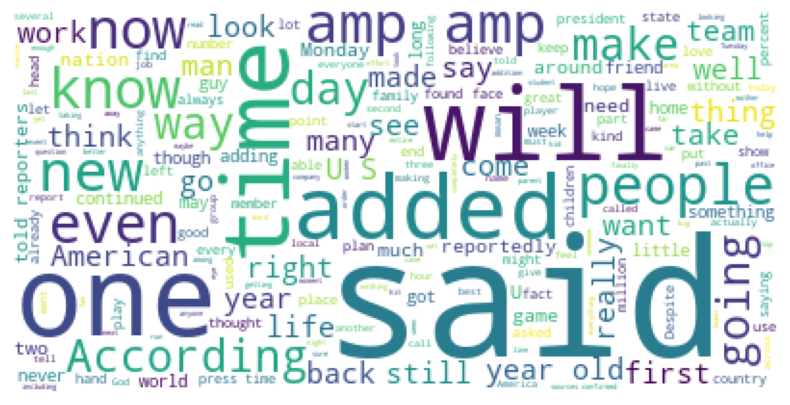

2


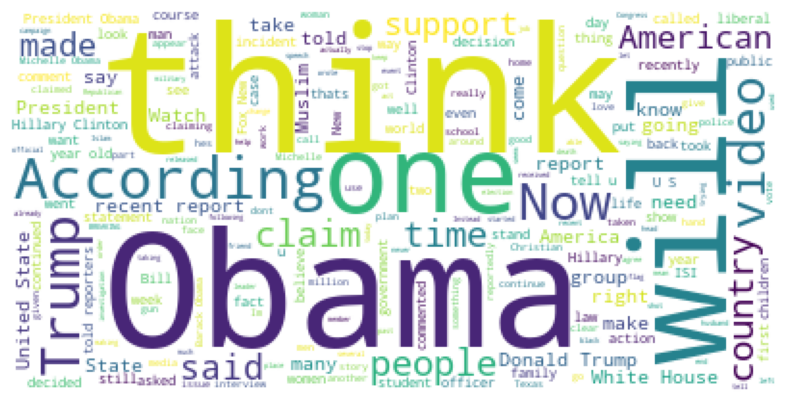

3


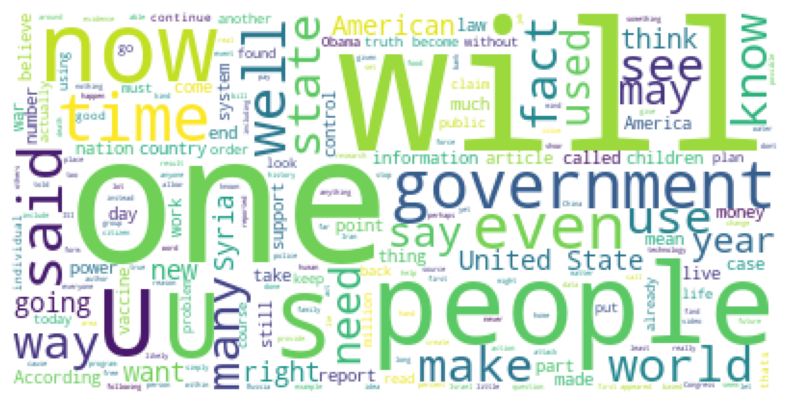

4


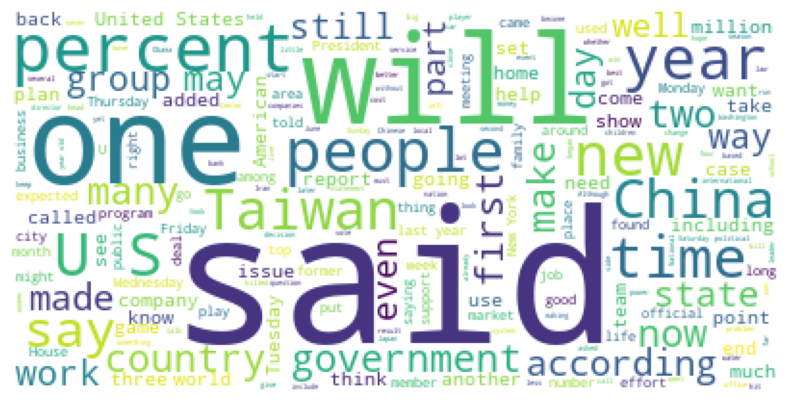

In [ ]:
for label in train.label.unique():
    print(label)
    text_sen = ' '.join(train.text[train.label==label])
    wordcloud_sen = WordCloud(background_color="white").generate(text_sen)
    # Generate plot
    plt.figure( figsize=(10,5))
    plt.imshow(wordcloud_sen)
    plt.axis("off")
    plt.show()

In [ ]:
tokenizer = RegexpTokenizer(r'[A-Za-z0-9_@#\']+')
stop_words_list = set(nltk.corpus.stopwords.words('english'))
def remove_stop_words(words):
    return list(filter(lambda x: x not in stop_words_list, words))

In [ ]:
for label in train.label.unique():
    print(label)
    text_raw = ' '.join(train.text[train.label==label])
    tokens_raw = tokenizer.tokenize(text_raw)
    tokens_wo_stopwords = remove_stop_words(tokens_raw)
    print('#tokens before removing stopwords: '+str(len(tokens_raw)))
    print('#tokens before after stopwords: '+str(len(tokens_wo_stopwords)))
    freq_tokens = FreqDist(tokens_wo_stopwords)
    # freq_sen.tabulate()
    df_tokens_word_count = pd.DataFrame(freq_tokens.items(), columns=['word', 'frequency'])
    df_tokens_word_count = df_tokens_word_count.sort_values(by=['frequency'], ascending=False)
    print('top 20 tokens')
    print(df_tokens_word_count.head(20))

1
#tokens before removing stopwords: 4276377
#tokens before after stopwords: 2663786
top 20 tokens
         word  frequency
120         '      58503
45       said      34708
137         I      28637
89        The      12372
200      time      10783
111       one      10321
114     would       9529
27       like       8961
681        'I       6937
17       year       6715
693     could       6056
586       get       6015
183      even       5837
633       new       5671
600     added       5434
12612     amp       5240
793    people       5174
63        old       4931
517    Monday       4901
318     first       4848
2
#tokens before removing stopwords: 1362940
#tokens before after stopwords: 836786
top 20 tokens
          word  frequency
170        The       9610
11       Obama       7057
45       think       6147
128          I       6077
152       What       4948
69       Trump       4887
59          In       3182
134        one       3000
672  According       2996
165       This    

In [ ]:
df_satire = train[train.label==1].copy()
df_hoax = train[train.label==2].copy()
df_propaganda = train[train.label==3].copy()
df_reliable = train[train.label==4].copy()

In [ ]:
for df in [df_satire,df_hoax,df_propaganda,df_reliable]:
    df['sentence_length'] = df.apply(lambda x: len(x['text']), axis = 1)
    df['words_number'] = df.apply(lambda x: len(tokenizer.tokenize(x['text'])), axis = 1)


In [ ]:
df_satire['sentence_length'].describe()

count    14047.000000
mean      1772.667616
std       1513.921565
min         14.000000
25%        734.000000
50%        985.000000
75%       3202.500000
max      10881.000000
Name: sentence_length, dtype: float64

In [ ]:
df_hoax['sentence_length'].describe()

count     6942.000000
mean      1144.799481
std        469.639052
min         11.000000
25%        861.250000
50%       1102.000000
75%       1370.000000
max      13715.000000
Name: sentence_length, dtype: float64

In [ ]:
df_propaganda['sentence_length'].describe()

count     17870.000000
mean       5535.197090
std        8826.124756
min          10.000000
25%        1578.000000
50%        4211.000000
75%        7335.000000
max      735608.000000
Name: sentence_length, dtype: float64

In [ ]:
df_reliable['sentence_length'].describe()

count     9995.000000
mean      2689.952976
std       2113.268025
min         10.000000
25%       1214.000000
50%       2124.000000
75%       3749.000000
max      25821.000000
Name: sentence_length, dtype: float64

In [ ]:
for df in [df_satire,df_hoax,df_propaganda,df_reliable]:
    df['sentiment_analysis_socre'] = df.apply(lambda x: sia.polarity_scores(x['text'])['compound'], axis = 1)

In [ ]:
for df in [df_satire,df_hoax,df_propaganda,df_reliable]:
    df['sentiment_analysis_socre'] = df.apply(lambda x: sia.polarity_scores(x['text'])['compound'], axis = 1)

In [ ]:
df_satire['sentiment']='neutral'
df_satire.loc[df_satire.sentiment_analysis_socre>0,'sentiment']='pos'
df_satire.loc[df_satire.sentiment_analysis_socre<0,'sentiment']='neg'
df_satire['sentiment'].value_counts()/len(df_satire['sentiment'])

pos        0.638072
neg        0.354026
neutral    0.007902
Name: sentiment, dtype: float64

In [ ]:
df_hoax['sentiment']='neutral'
df_hoax.loc[df_hoax.sentiment_analysis_socre>0,'sentiment']='pos'
df_hoax.loc[df_hoax.sentiment_analysis_socre<0,'sentiment']='neg'
df_hoax['sentiment'].value_counts()

neg        4142
pos        2781
neutral      19
Name: sentiment, dtype: int64

In [ ]:
df_propaganda['sentiment']='neutral'
df_propaganda.loc[df_propaganda.sentiment_analysis_socre>0,'sentiment']='pos'
df_propaganda.loc[df_propaganda.sentiment_analysis_socre<0,'sentiment']='neg'
df_propaganda['sentiment'].value_counts()

neg        9054
pos        7528
neutral    1288
Name: sentiment, dtype: int64

In [ ]:
df_reliable['sentiment']='neutral'
df_reliable.loc[df_reliable.sentiment_analysis_socre>0,'sentiment']='pos'
df_reliable.loc[df_reliable.sentiment_analysis_socre<0,'sentiment']='neg'
df_reliable['sentiment'].value_counts()

pos        6116
neg        3598
neutral     281
Name: sentiment, dtype: int64

In [ ]:
for df in [df_satire,df_hoax,df_propaganda,df_reliable]:
    df['entity_numbers'] = df.apply(lambda x: len(nlp(x['text']).ents), axis = 1)

In [ ]:
df_satire['entity_numbers'].describe()

count    14047.000000
mean        22.096889
std         20.124596
min          0.000000
25%          9.000000
50%         13.000000
75%         31.000000
max        206.000000
Name: entity_numbers, dtype: float64

In [ ]:
df_hoax['entity_numbers'].describe()

count    6942.000000
mean       15.864448
std         8.271536
min         0.000000
25%        10.000000
50%        15.000000
75%        20.000000
max       200.000000
Name: entity_numbers, dtype: float64

In [ ]:
df_propaganda['entity_numbers'].describe()

count    17870.000000
mean        61.744656
std         91.056158
min          0.000000
25%         14.000000
50%         42.000000
75%         82.000000
max       5701.000000
Name: entity_numbers, dtype: float64

In [ ]:
df_reliable['entity_numbers'].describe()

count    9995.000000
mean       47.096948
std        34.893169
min         0.000000
25%        23.000000
50%        39.000000
75%        63.000000
max       493.000000
Name: entity_numbers, dtype: float64

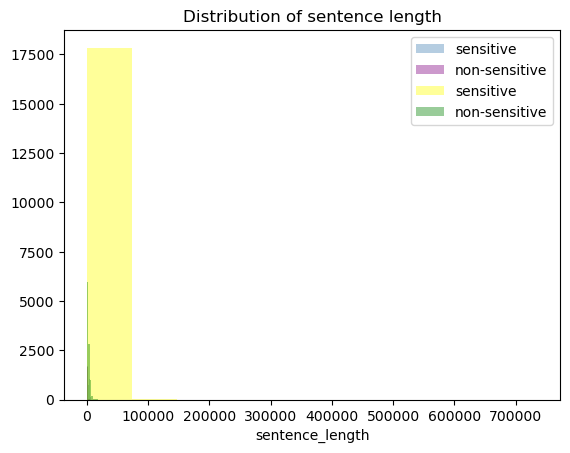

In [ ]:
sns.distplot(df_satire['sentence_length'],bins=10,kde=False,hist_kws={"color":"steelblue"},label="sensitive")
sns.distplot(df_hoax['sentence_length'],bins=10,kde=False,hist_kws={"color":"purple"},label="non-sensitive")
sns.distplot(df_propaganda['sentence_length'],bins=10,kde=False,hist_kws={"color":"yellow"},label="sensitive")
sns.distplot(df_reliable['sentence_length'],bins=10,kde=False,hist_kws={"color":"green"},label="non-sensitive")

plt.title("Distribution of sentence length")
plt.legend()
plt.show()

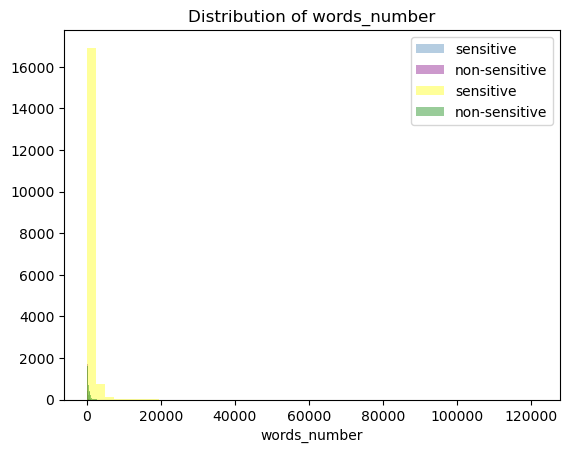

In [ ]:
sns.distplot(df_satire['words_number'],bins=50,kde=False,hist_kws={"color":"steelblue"},label="sensitive")
sns.distplot(df_hoax['words_number'],bins=50,kde=False,hist_kws={"color":"purple"},label="non-sensitive")
sns.distplot(df_propaganda['words_number'],bins=50,kde=False,hist_kws={"color":"yellow"},label="sensitive")
sns.distplot(df_reliable['words_number'],bins=50,kde=False,hist_kws={"color":"green"},label="non-sensitive")

plt.title("Distribution of words_number")
plt.legend()
plt.show()

In [ ]:
sia = SentimentIntensityAnalyzer()
nlp = en_core_web_sm.load()


In [ ]:
sns.distplot(df_satire['sentiment_analysis_socre'],bins=10,kde=True,hist_kws={"color":"steelblue"},label="satire")
sns.distplot(df_hoax['sentiment_analysis_socre'],bins=10,kde=True,hist_kws={"color":"purple"},label="non-hoax")
sns.distplot(df_propaganda['sentiment_analysis_socre'],bins=10,kde=True,hist_kws={"color":"yellow"},label="propaganda")
sns.distplot(df_reliable['sentiment_analysis_socre'],bins=10,kde=True,hist_kws={"color":"green"},label="reliable")


plt.title("Distribution of sentiment analysis score")
plt.legend()
plt.show()